## __인근 관측소 선택 방법__

----------------------------------------------------------------------
### __Intro__
* 본 ipynb는 유동인구데이터와 기상데이터 간 인사이트를 발견하기 위해, 인근 관측소를 탐색하는 과정을 다룹니다.
* 대용량 데이터를 다루지 않으므로, 본 ipynb를 실항하는 것 만으로도 최종 결과 파일(인근 관측소.csv)를 얻을 수 있습니다.
* 관측소 선택에 사용되는 shp파일은 공식 깃허브에서 제공합니다.
* 본 프로젝트는 무인으로 운영되며, 서울 시 내 조밀하게 분포되어 있는 방재기상관측소의 데이터를 사용합니다.
* 기상자료 수집은 API를 통해 이루어 지기에 data preprocessing 폴더에서는 다루지 않습니다.

### __사용 데이터__
* 실시간 도시 데이터 집계 범위: https://data.seoul.go.kr/dataList/OA-21778/A/1/datasetView.do
* 관측소(방재기상관측소) 위치: https://apihub.kma.go.kr/

### __목적__
* 지하철 역 별 기상 관측소 선택

### __필요성__
* 기상 현상은 지역에 따라 유의미한 차이가 발생하며, 이는 같은 서울시 내부에서도 발생할 수 있음
* 따라서, 일반적으로 기상 데이터를 사용할 때는, 대상지역의 인근 관측소의 기상자료를 사용함
* 본 프로젝트는 RP 데이터의 집계 범위(지하철역 범위)에 대표할 수 있는 기상 관측소를 공간 분석을 통해 선택하는 과정을 다룸

### 구조
* shape: 각 데이터의 shp 파일이 저장된 폴더
* 인구수 가중치 계산 과정.ipynb: 인근 관측소 선택 방법 시각화 및 최종 파일 출력

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
import koreanize_matplotlib
from shapely.geometry import Point

### __1. RP 데이터의 집계 범위 데이터 불러오기__

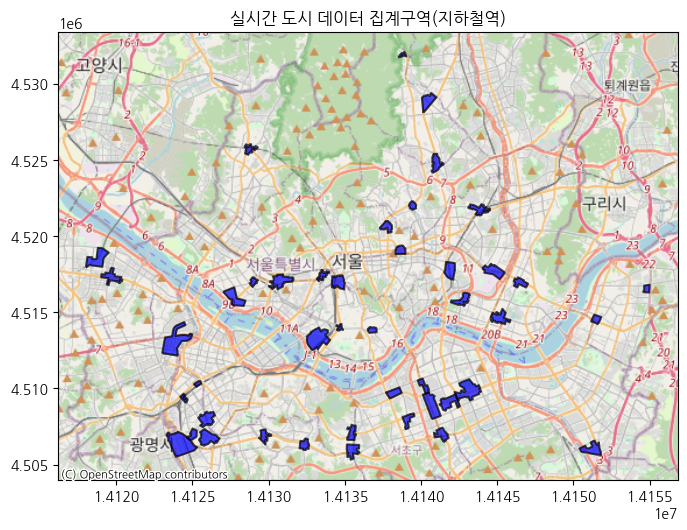

In [2]:
gdf_border = gpd.read_file('./shape/실시간 도시 데이터 집계구역.shp')
gdf_border = gdf_border.to_crs(epsg=3857)
fig, ax1 = plt.subplots(figsize=(8, 6))
gdf_border.plot(ax=ax1, color="blue", edgecolor="black", linewidth=1.5, alpha=0.7, legend=True)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("실시간 도시 데이터 집계구역(지하철역)")
plt.show()

### __2. RP 데이터의 집계 범위에 중점 계산__

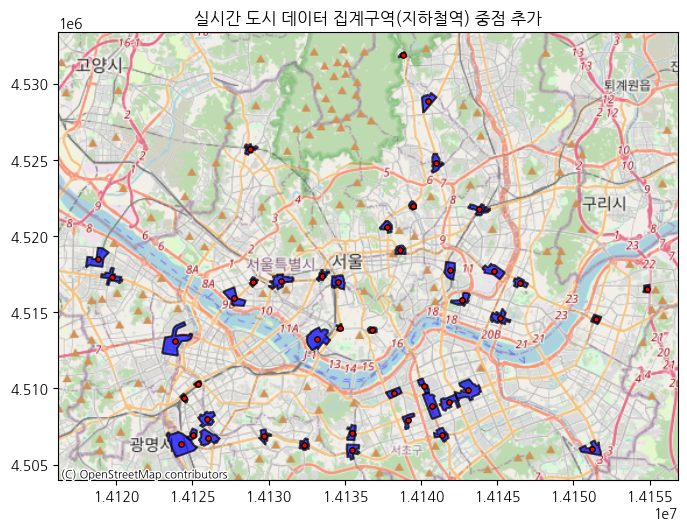

In [3]:
gdf_border = gdf_border.to_crs(epsg=3857)
gdf_border['centroid'] = gdf_border.geometry.centroid
fig, ax2 = plt.subplots(figsize=(8, 6))
gdf_border.plot(ax=ax2, color="blue", edgecolor="black", linewidth=1.5, alpha=0.7, legend=True)
gdf_border.set_geometry('centroid').plot(ax=ax2, color='red', edgecolor="black", markersize=15)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("실시간 도시 데이터 집계구역(지하철역) 중점 추가")
plt.show()

### __3. 방재관측소 위치 불러오기__

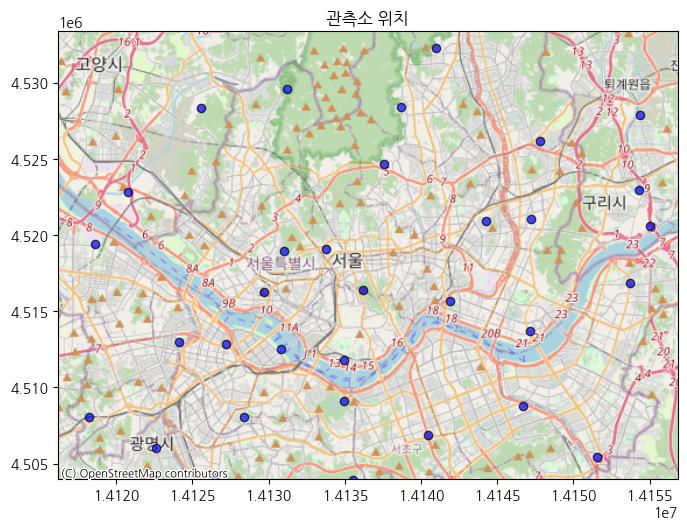

In [4]:
df = pd.read_csv('./shape/station_location.csv')
geometry = [Point(xy) for xy in zip(df['LON'], df['LAT'])]
gdf_station = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
gdf_station = gdf_station.to_crs(epsg=3857)
fig, ax3 = plt.subplots(figsize=(8, 6))
gdf_station.plot(ax=ax3, color="blue", edgecolor="black", alpha=0.7, legend=True)
plt.xlim(ax1.get_xlim())
plt.ylim(ax1.get_ylim())
ctx.add_basemap(ax3, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("관측소 위치")
plt.show()

In [5]:
gdf_station.head()

,STN,LON,LAT,STN_SP,HT,HT_WD,LAU,STN.1,STN_KO,STN_EN,FCT_ID,LAW_ID,BASIN,Unnamed: 13,geometry
0,90,128.56473,38.25085,41211110,17.53,10.0,4111,105,속초,----,11D20402,5182033035,282,NaN,POINT (14311760.278 4614923.364)
1,92,128.66298,38.05903,20111000,75.40,10.0,4113,113,양양(공),----,11D20403,5183032021,221,NaN,POINT (14322697.418 4587768.132)
2,93,127.75443,37.94738,41211111,95.78,10.0,4101,101,북춘천,----,11D10301,5111025024,291,NaN,POINT (14221558.094 4571995.036)
3,95,127.30420,38.14787,41211110,155.48,12.6,4095,101,철원,----,11D10101,5178025624,293,NaN,POINT (14171438.72 4600335.996)
4,96,131.86983,37.23952,01111100,99.08,0.0,4115,115,독도,----,11E00102,4794025027,211,NaN,POINT (14679682.327 4472545.58)


### __4. 인근 관측소 선택 후 정리__

In [6]:
if gdf_border.crs != gdf_station.crs:
    gdf_station = gdf_station.to_crs(gdf_border.crs)

nearest_points = []
nearest_distances = []
station_names = []
station_codes = []

for point in gdf_border.geometry:
    distances = gdf_station.geometry.distance(point)
    nearest_idx = distances.idxmin()
    nearest_point = gdf_station.loc[nearest_idx, 'geometry']
    station_name = gdf_station.loc[nearest_idx, 'STN_KO']
    station_code = gdf_station.loc[nearest_idx, 'STN']
    nearest_distance = distances.min()
    nearest_points.append(nearest_point)
    nearest_distances.append(nearest_distance)
    station_names.append(station_name)
    station_codes.append(station_code)

gdf_border['nearest_B_point'] = nearest_points  # 가장 가까운 B 포인트
gdf_border['distance_to_B'] = nearest_distances  # 거리
gdf_border['station_name'] = station_names
gdf_border['Station Code'] = station_codes
gdf_border.head()

c:\Users\User\anaconda3\envs\BigProject\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


,CATEGORY,AREA_CD,AREA_NM,geometry,centroid,nearest_B_point,distance_to_B,station_name,Station Code
0,인구밀집지역,POI013,가산디지털단지역,"POLYGON ((14123479.946 4506566.907, 14123460.4...",POINT (14124228.881 4506350.357),POINT (14122581.708530797 4506038.8983128695),980.968422,광명,437
1,인구밀집지역,POI014,강남역,"POLYGON ((14140721.231 4507982.119, 14140660.3...",POINT (14140706.026 4508869.208),POINT (14140470.750701277 4506873.568306652),1136.496863,서초,401
2,인구밀집지역,POI015,건대입구역,"POLYGON ((14145376.267 4515179.281, 14145408.7...",POINT (14145166.806 4514640.908),POINT (14147149.920148874 4513724.582848873),1459.184227,광진,413
3,인구밀집지역,POI016,고덕역,"POLYGON ((14154642.022 4516473.69, 14154644.50...",POINT (14154813.087 4516534.103),POINT (14153714.430520952 4516830.205715557),932.797144,강동,402
4,인구밀집지역,POI017,고속터미널역,"POLYGON ((14138637.373 4509934.307, 14138646.6...",POINT (14138227.076 4509706.918),POINT (14134961.549101917 4509081.906651446),2809.826290,현충원,889


### __5. 선택된 관측소 확인 후 필요한 데이터만 추출__

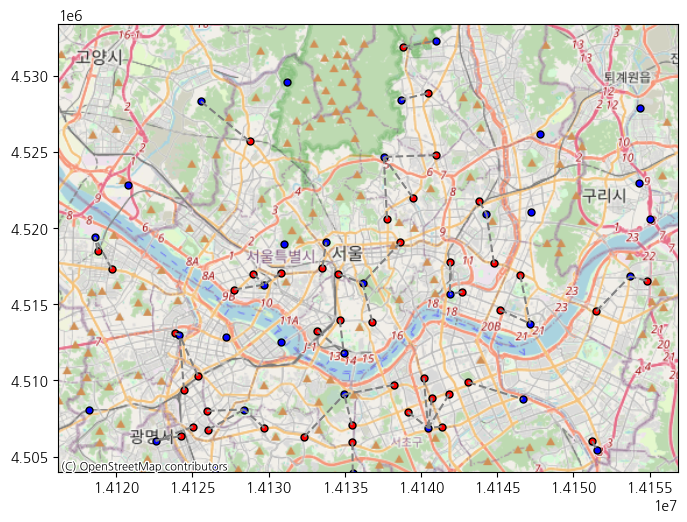

In [7]:
fig, ax4 = plt.subplots(figsize=(8, 6))
gdf_border.set_geometry('centroid').plot(ax=ax4, color='red', markersize=25, edgecolor="black")
gdf_station.plot(ax=ax4, color='blue', markersize=25, edgecolor="black")

for idx, row in gdf_border.iterrows():
    plt.plot([row.geometry.centroid.x, row.nearest_B_point.x], [row.geometry.centroid.y, row.nearest_B_point.y], color='gray', linestyle='--')

plt.xlim(ax1.get_xlim())
plt.ylim(ax1.get_ylim())
ctx.add_basemap(ax4, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

final_df = gdf_border[['AREA_NM','station_name', 'Station Code']]
final_df.columns = ['Area name','station_name', 'Station Code']
final_df.to_csv('인근 관측소.csv')